<a href="https://colab.research.google.com/github/ErikLarssonDev/Time-Series/blob/main/Stock_Price_Prediction_and_Forecasting_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Prediction and Forecasting with LSTM
The dataset used in this notebook can be found here: https://finance.yahoo.com/quote/MSFT/history/. I used the maximum time period Mar 13, 1986 - Oct 31, 2023.

## Preparing the data

In [11]:
import pandas as pd

df = pd.read_csv('MSFT.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060396,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062553,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063632,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062014,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060936,47894400
...,...,...,...,...,...,...,...
9480,2023-10-24,331.299988,331.839996,327.600006,330.529999,330.529999,31153600
9481,2023-10-25,345.019989,346.200012,337.619995,340.670013,340.670013,55053800
9482,2023-10-26,340.540009,341.630005,326.940002,327.890015,327.890015,37828500
9483,2023-10-27,330.429993,336.720001,328.399994,329.809998,329.809998,29835200


In [12]:
df = df[['Date', 'Close']]
df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9480,2023-10-24,330.529999
9481,2023-10-25,340.670013
9482,2023-10-26,327.890015
9483,2023-10-27,329.809998


In [13]:
df['Date'] # Want this as DateTime

0       1986-03-13
1       1986-03-14
2       1986-03-17
3       1986-03-18
4       1986-03-19
           ...    
9480    2023-10-24
9481    2023-10-25
9482    2023-10-26
9483    2023-10-27
9484    2023-10-30
Name: Date, Length: 9485, dtype: object

In [14]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [15]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

<ipython-input-15-f6fc52bb0fa5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9480   2023-10-24
9481   2023-10-25
9482   2023-10-26
9483   2023-10-27
9484   2023-10-30
Name: Date, Length: 9485, dtype: datetime64[ns]

In [16]:
df.index = df.pop('Date')
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2023-10-24,330.529999
2023-10-25,340.670013
2023-10-26,327.890015


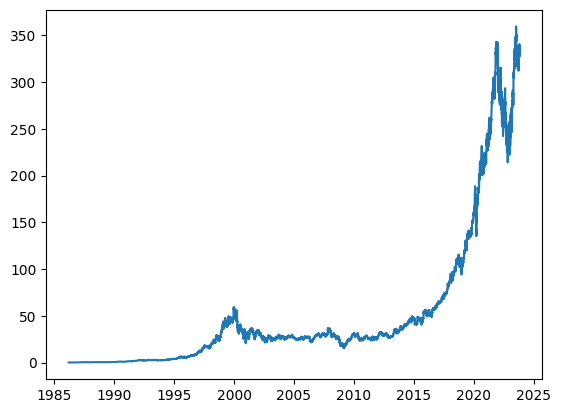

In [17]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [23]:
# Transforming the data to a supervised learning problem
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

windowed_df = df_to_windowed_df(df,
                                '1986-03-18', # Earliest possible start date
                                '2023-10-30',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,1986-03-18,0.097222,0.100694,0.102431,0.099826
1,1986-03-19,0.100694,0.102431,0.099826,0.098090
2,1986-03-20,0.102431,0.099826,0.098090,0.095486
3,1986-03-21,0.099826,0.098090,0.095486,0.092882
4,1986-03-24,0.098090,0.095486,0.092882,0.090278
...,...,...,...,...,...
9477,2023-10-24,331.320007,326.670013,329.320007,330.529999
9478,2023-10-25,326.670013,329.320007,330.529999,340.670013
9479,2023-10-26,329.320007,330.529999,340.670013,327.890015
9480,2023-10-27,330.529999,340.670013,327.890015,329.809998


In [24]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((9482,), (9482, 3, 1), (9482,))

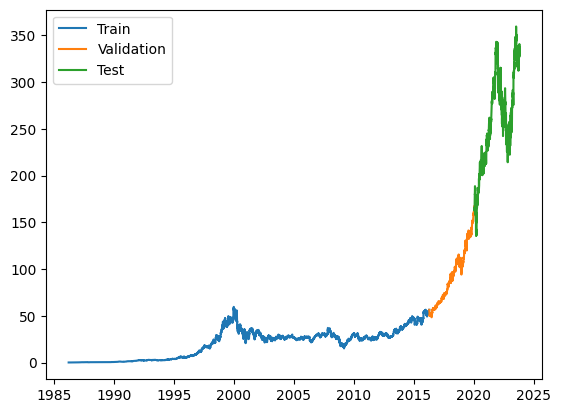

In [25]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

## Creating the LSTM model

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
238/238 [==============================] - 5s 7ms/step - loss: 101.0307 - mean_absolute_error: 4.3943 - val_loss: 2646.7708 - val_mean_absolute_error: 40.4314
Epoch 2/100
238/238 [==============================] - 1s 4ms/step - loss: 0.3534 - mean_absolute_error: 0.3445 - val_loss: 2372.9436 - val_mean_absolute_error: 37.4548
Epoch 3/100
238/238 [==============================] - 1s 4ms/step - loss: 0.3126 - mean_absolute_error: 0.3241 - val_loss: 2250.4563 - val_mean_absolute_error: 35.9859
Epoch 4/100
238/238 [==============================] - 1s 4ms/step - loss: 0.3295 - mean_absolute_error: 0.3369 - val_loss: 2214.0999 - val_mean_absolute_error: 35.5698
Epoch 5/100
238/238 [==============================] - 1s 4ms/step - loss: 0.3464 - mean_absolute_error: 0.3443 - val_loss: 2214.3118 - val_mean_absolute_error: 35.7429
Epoch 6/100
238/238 [==============================] - 1s 4ms/step - loss: 0.3222 - mean_absolute_error: 0.3353 - val_loss: 2182.7378 - val_mean_absolute

## Evaluating the LSTM model

238/238 [==============================] - 2s 2ms/step


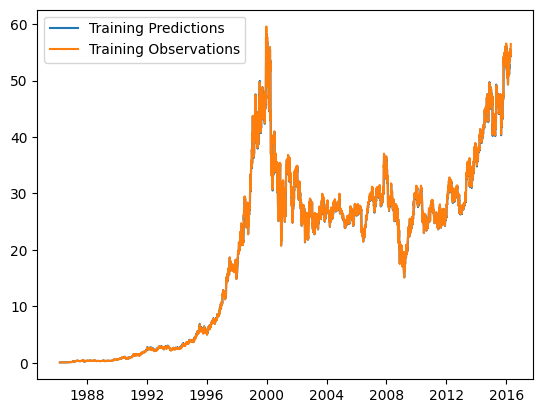

In [27]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

30/30 [==============================] - 0s 2ms/step


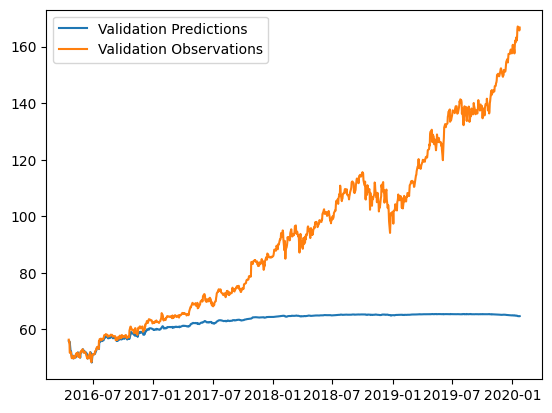

In [28]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

30/30 [==============================] - 0s 2ms/step


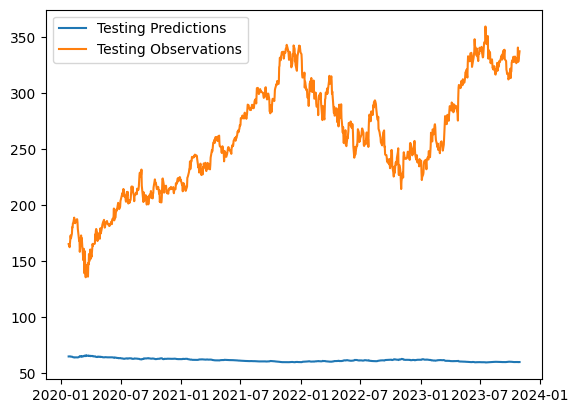

In [29]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

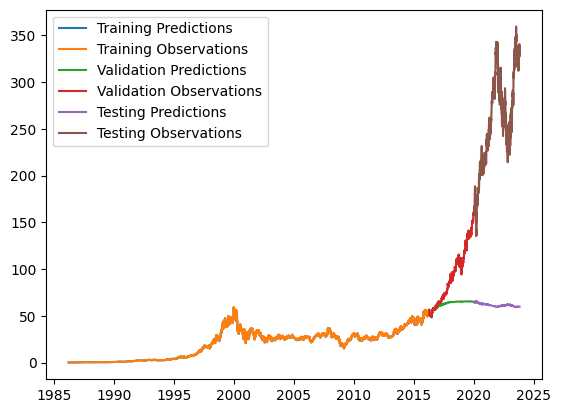

In [30]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [31]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 21ms/step


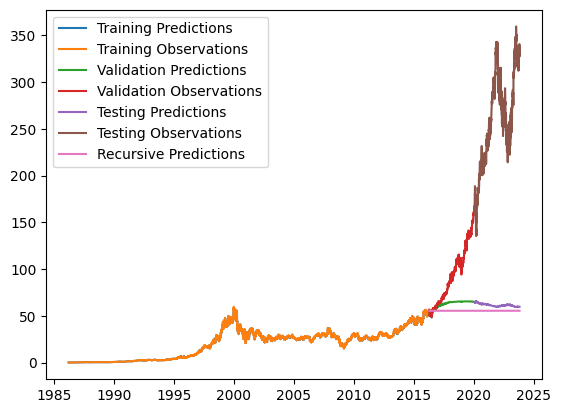

In [32]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])

## Removing old training data to focus more on recent trends and retraining the model
As seen in the plots before, the predictions are quite bad. One reason for this could be that we are training on a different distribution than we are testing on. It is difficult to say if and how the stock price of 1990 actually affects the stock price in 2023.

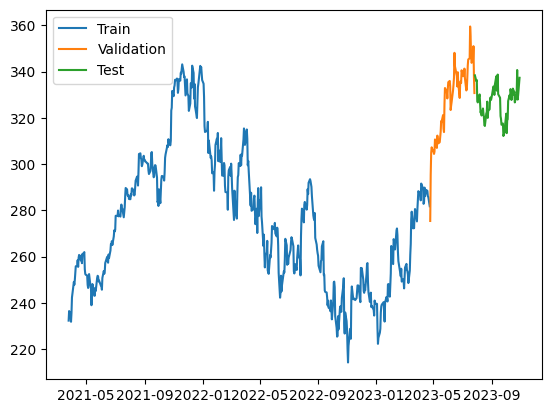

In [33]:
windowed_df = df_to_windowed_df(df,
                                '2021-03-25',
                                '2023-10-30',
                                n=3)
dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [34]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
17/17 [==============================] - 0s 9ms/step - loss: 21329.5977 - mean_absolute_error: 128.7864 - val_loss: 1496.2070 - val_mean_absolute_error: 35.7473
Epoch 2/100
17/17 [==============================] - 0s 7ms/step - loss: 2514.6951 - mean_absolute_error: 42.7474 - val_loss: 3849.8127 - val_mean_absolute_error: 59.9550
Epoch 3/100
17/17 [==============================] - 0s 5ms/step - loss: 1040.4025 - mean_absolute_error: 25.6182 - val_loss: 3159.9958 - val_mean_absolute_error: 53.8977
Epoch 4/100
17/17 [==============================] - 0s 6ms/step - loss: 658.4894 - mean_absolute_error: 21.0386 - val_loss: 1533.7990 - val_mean_absolute_error: 36.6086
Epoch 5/100
17/17 [==============================] - 0s 6ms/step - loss: 497.4945 - mean_absolute_error: 18.3257 - val_loss: 1617.5339 - val_mean_absolute_error: 37.5903
Epoch 6/100
17/17 [==============================] - 0s 7ms/step - loss: 426.7793 - mean_absolute_error: 16.9733 - val_loss: 1191.4648 - val_mean

17/17 [==============================] - 0s 2ms/step


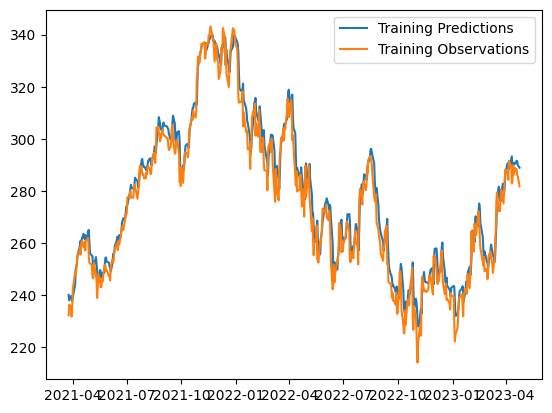

In [35]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

3/3 [==============================] - 0s 5ms/step


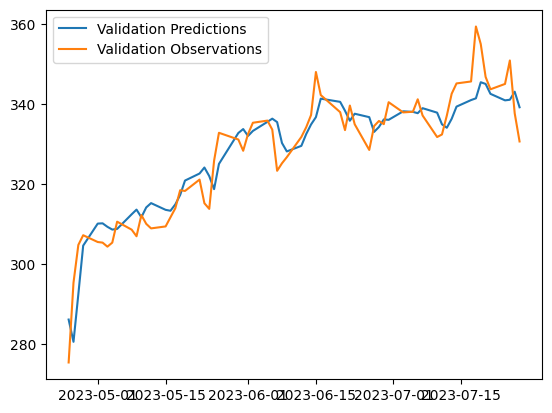

In [36]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

3/3 [==============================] - 0s 4ms/step


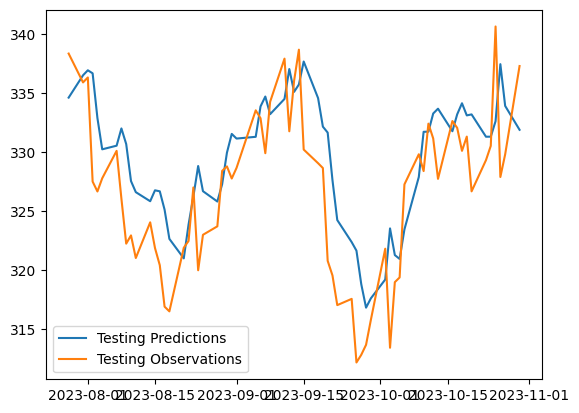

In [37]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

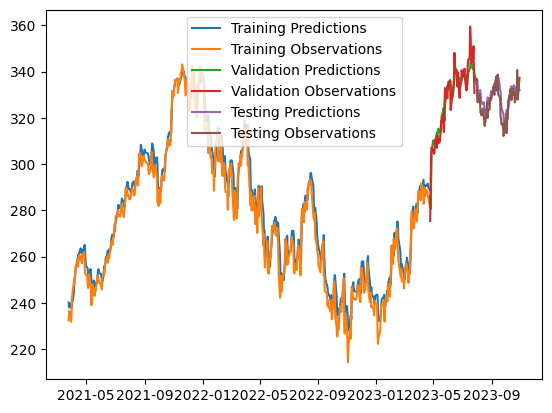

In [38]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [39]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 20ms/step


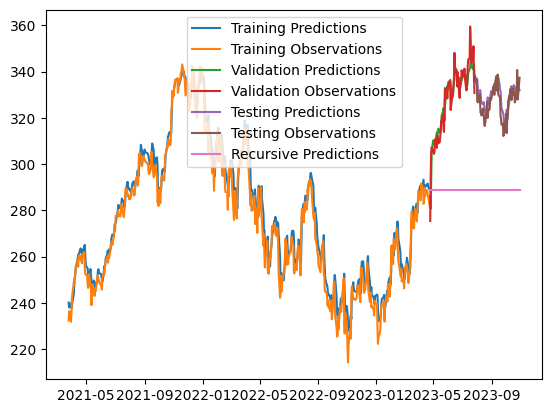

In [40]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])